# Regularyzacja w modelu regresji - wstęp

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` z `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [2]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + stats.norm.rvs(size=n, loc=2, scale=2)

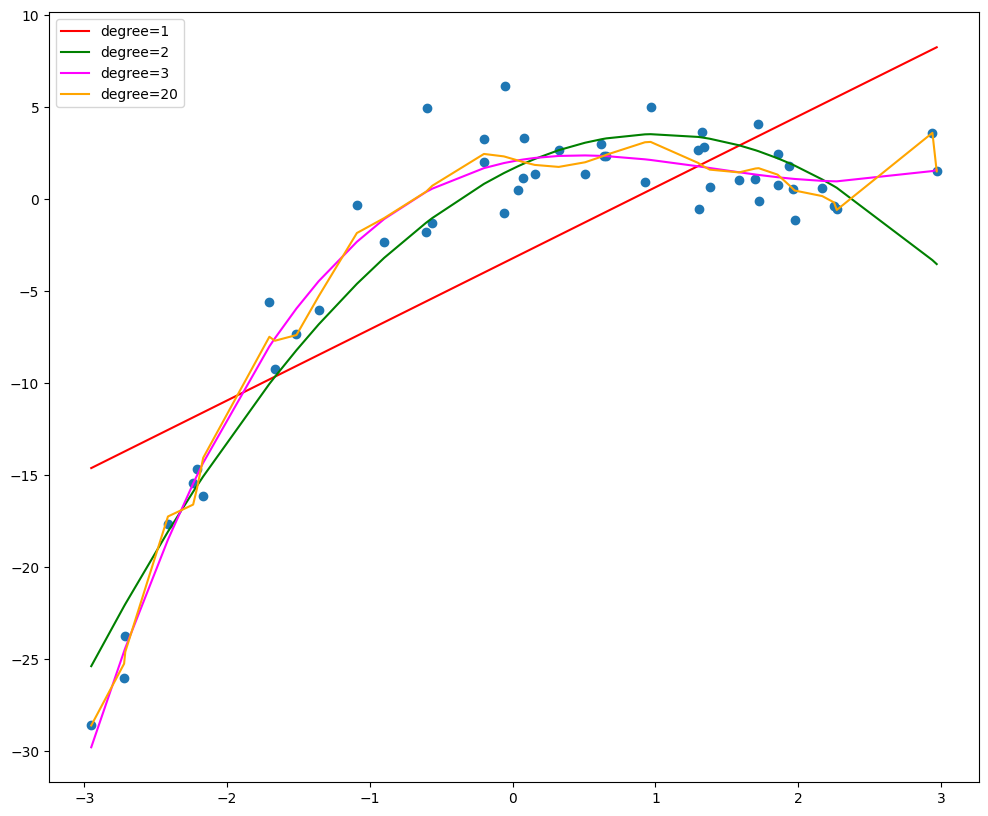

In [3]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanej pary punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [4]:
# Rigde - powinno wygładzać wielomian (zwalczamy problem przeuczenia modelu)
# Sposob I
X = x.reshape(-1, 1)
polynomial_features_20 = PolynomialFeatures(degree=20,include_bias = False)
X20 = polynomial_features_20.fit_transform(X)

In [5]:
X20.shape

(50, 20)

In [6]:
X20

array([[ 1.58572295e+00,  2.51451728e+00,  3.98732776e+00,
         6.32279714e+00,  1.00262045e+01,  1.58987827e+01,
         2.52110646e+01,  3.99777637e+01,  6.33936575e+01,
         1.00524778e+02,  1.59404447e+02,  2.52771290e+02,
         4.00825237e+02,  6.35597777e+02,  1.00788198e+03,
         1.59822159e+03,  2.53433666e+03,  4.01875581e+03,
         6.37263333e+03,  1.01052309e+04],
       [-5.55853613e-02,  3.08973239e-03, -1.71743892e-04,
         9.54644627e-06, -5.30642665e-07,  2.94959643e-08,
        -1.63954383e-09,  9.11346364e-11, -5.06575169e-12,
         2.81581638e-13, -1.56518171e-14,  8.70011910e-16,
        -4.83599264e-17,  2.68810398e-18, -1.49419231e-19,
         8.30552195e-21, -4.61665439e-22,  2.56618402e-23,
        -1.42642266e-24,  7.92882190e-26],
       [ 1.55144132e-01,  2.40697016e-02,  3.73427294e-03,
         5.79350533e-04,  8.98828353e-05,  1.39447944e-05,
         2.16345302e-06,  3.35647040e-07,  5.20736686e-08,
         8.07892408e-09,  1.2

In [7]:
X20_scale = StandardScaler().fit_transform(X20) # (x - mean) / std (aby móc użyć Ridge lub Lasso najpierw trzeba zeskalować kolumny X)
X20_scale

array([[ 8.32859186e-01, -4.40616967e-02,  3.86042680e-01,
        -3.40389694e-01,  1.42146797e-01, -3.94946682e-01,
         4.77468288e-02, -3.79008711e-01,  9.62070369e-03,
        -3.52880620e-01, -1.00738486e-02, -3.30846052e-01,
        -2.33345821e-02, -3.14310825e-01, -3.37002509e-02,
        -3.02045479e-01, -4.22644513e-02, -2.92749428e-01,
        -4.94561775e-02, -2.85491784e-01],
       [-1.92610165e-01, -1.04028461e+00, -5.19278199e-02,
        -6.51127435e-01, -7.34032236e-03, -4.88363975e-01,
         1.24473163e-03, -4.06578514e-01, -4.32627598e-03,
        -3.60946028e-01, -1.41892474e-02, -3.33193823e-01,
        -2.45386605e-02, -3.14991977e-01, -3.40507490e-02,
        -3.02242623e-01, -4.23661354e-02, -2.92806383e-01,
        -4.94856077e-02, -2.85508216e-01],
       [-6.09489560e-02, -1.03196236e+00, -5.14987991e-02,
        -6.51099432e-01, -7.33897433e-03, -4.88363893e-01,
         1.24473563e-03, -4.06578513e-01, -4.32627597e-03,
        -3.60946028e-01, -1.4

In [8]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y) #definiujemy Ridge z zadanym parametrem i od razu dopasowujemy do zeskalowanych danych
ridge01

Ridge(alpha=0.1)

In [10]:
#żeby porównanie było fair z ridge robimy to na zeskalowanych danych
lm =  LinearRegression().fit(X20_scale,y)

In [11]:
print(ridge01.coef_) # [b1, b2, ..., b20] w ridge (bez wyrazu wolnego)
print(lm.coef_) # [b1, b2, ..., b20] w zwykłym lm (bez wyrazu wolnego)


[ 2.94219326 -4.30475484  2.9045523  -1.33099213 -0.17691869 -0.13748043
 -0.14427888  0.40447793  0.53375195  0.61095396  0.90988672  0.58945175
  0.82005192  0.41101887  0.33971876  0.12870536 -0.4135816  -0.22358199
 -1.33816824 -0.62735102]
[-3.71300596e+00 -2.85315622e+00  1.63894778e+02 -2.33511982e+02
 -1.75636824e+03  5.87007591e+03  9.37951686e+03 -5.95654135e+04
 -2.20098286e+04  3.10323776e+05  1.78266466e+03 -9.22382037e+05
  9.57555348e+04  1.62737346e+06 -1.90900058e+05 -1.68407673e+06
  1.52141631e+05  9.42267822e+05 -4.45488318e+04 -2.19580705e+05]


In [12]:
print(ridge01.intercept_) 
print(lm.intercept_) 
# wyrazy wolne poszczególnych metod

-2.2497167792190833
-2.249716779211438


In [13]:
ridge01_params = [ridge01.intercept_] + list(ridge01.coef_[1:])
ridge01_params # wyraz wolny i wspolczynniki regresji grzbietowej

[-2.2497167792190833,
 -4.304754836677679,
 2.904552303010519,
 -1.330992132193658,
 -0.1769186908423914,
 -0.13748042509593397,
 -0.1442788766960161,
 0.4044779326324727,
 0.5337519537064612,
 0.6109539632481793,
 0.9098867243028601,
 0.5894517528015661,
 0.8200519228941757,
 0.4110188666824451,
 0.3397187603518303,
 0.12870536018944773,
 -0.4135815980033286,
 -0.2235819854744521,
 -1.3381682421534087,
 -0.6273510242870125]

In [14]:
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01.score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-2.2497167792190833, -4.304754836677679, 2.904552303010519, -1.330992132193658, -0.1769186908423914, -0.13748042509593397, -0.1442788766960161, 0.4044779326324727, 0.5337519537064612, 0.6109539632481793, 0.9098867243028601, 0.5894517528015661, 0.8200519228941757, 0.4110188666824451, 0.3397187603518303, 0.12870536018944773, -0.4135815980033286, -0.2235819854744521, -1.3381682421534087, -0.6273510242870125]
R2: 0.9602701164766698


In [15]:
#dla porównania regresja zwykła
lm_r2 = lm.score(X20_scale, y)
print("R2: {}".format(lm_r2))
#nieco wyżej, ale to na zb. treningowym, więc nic dziwnego

R2: 0.9647118159328073


In [16]:
## Sposob 2 - pipeline

ridge01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Ridge(alpha=0.1)
)
ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [17]:
ridge01_pipeline['ridge']

Ridge(alpha=0.1)

In [18]:
ridge01_params = [ridge01_pipeline['ridge'].intercept_] + list(ridge01_pipeline['ridge'].coef_[1:])
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params)) #współczynniki
ridge01_r2 = ridge01_pipeline['ridge'].score(X20_scale, y)
print("R2: {}".format(ridge01_r2)) #R^2

Współczynniki regresji z regularyzacja Ridge: [-2.2497167792190833, -4.304754836677679, 2.904552303010519, -1.330992132193658, -0.1769186908423914, -0.13748042509593397, -0.1442788766960161, 0.4044779326324727, 0.5337519537064612, 0.6109539632481793, 0.9098867243028601, 0.5894517528015661, 0.8200519228941757, 0.4110188666824451, 0.3397187603518303, 0.12870536018944773, -0.4135815980033286, -0.2235819854744521, -1.3381682421534087, -0.6273510242870125]
R2: 0.9602701164766698


In [19]:
ridge01.predict(X20_scale) #wartości dopasowane

array([  1.54861559,   1.97750366,   2.33025972,   1.22834843,
        -2.45564524,  -8.09467263,   2.63353767, -14.47285451,
         1.283307  , -28.71376819,  -4.57428285,   0.44903209,
         1.24154682,   0.26134984,   2.21766881,  -1.22371205,
         2.6154018 , -24.77263327,   2.21312215,  -6.04288504,
         0.06468464,   2.63432722,   2.09189534, -15.1833529 ,
         1.64911311, -18.75356978, -15.63094147,   2.05425013,
         2.15149675, -24.60610387,   2.02349959,   0.60123577,
         0.19142307,   0.62335177,   0.90128004,   2.49479459,
         0.89586096,   0.08115862,   1.6431393 ,   2.52560468,
         1.95639591,   2.40588452,   0.69268882,   1.96295564,
         2.51055165,   2.63445172,   2.52059454,   0.29797636,
         2.08476308,  -7.65448856])

In [20]:
ridge01_fittedvalues = ridge01_pipeline.predict(X) #wartości dopasowane obliczone za pomocą pipeline'a
ridge01_fittedvalues
#to samo co wcześniej - metody są równoważne

array([  1.54861559,   1.97750366,   2.33025972,   1.22834843,
        -2.45564524,  -8.09467263,   2.63353767, -14.47285451,
         1.283307  , -28.71376819,  -4.57428285,   0.44903209,
         1.24154682,   0.26134984,   2.21766881,  -1.22371205,
         2.6154018 , -24.77263327,   2.21312215,  -6.04288504,
         0.06468464,   2.63432722,   2.09189534, -15.1833529 ,
         1.64911311, -18.75356978, -15.63094147,   2.05425013,
         2.15149675, -24.60610387,   2.02349959,   0.60123577,
         0.19142307,   0.62335177,   0.90128004,   2.49479459,
         0.89586096,   0.08115862,   1.6431393 ,   2.52560468,
         1.95639591,   2.40588452,   0.69268882,   1.96295564,
         2.51055165,   2.63445172,   2.52059454,   0.29797636,
         2.08476308,  -7.65448856])

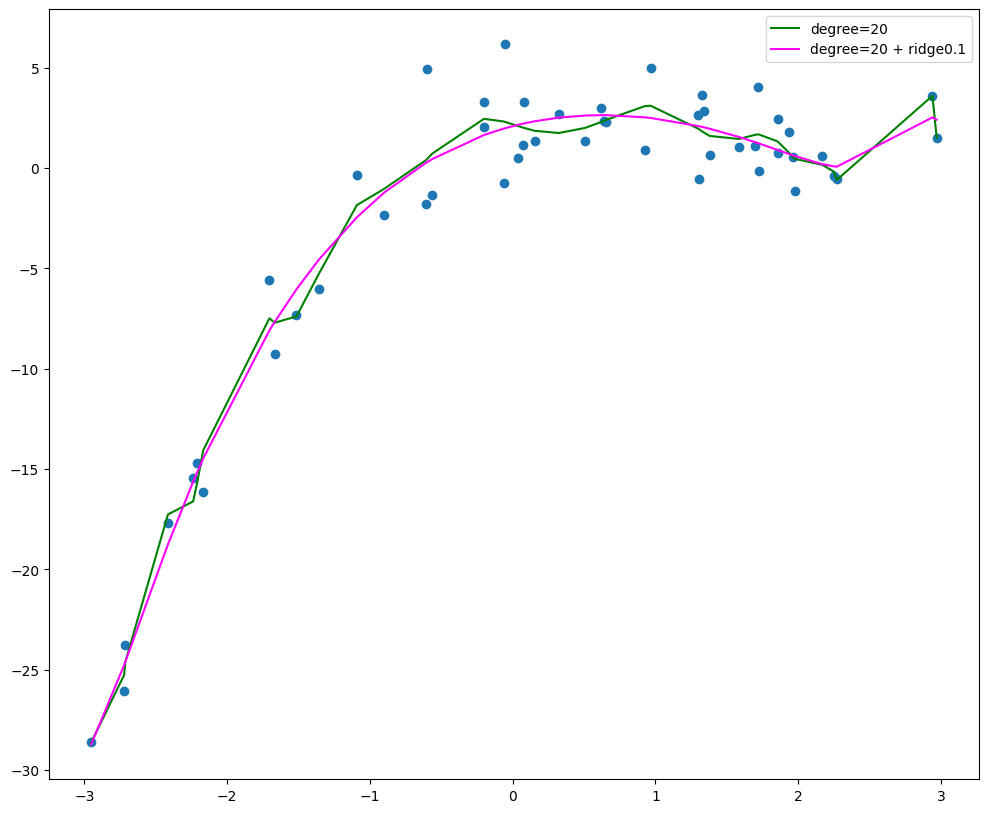

In [21]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()#jeśli chodzi o watości dopasowane, nie jest ważne, czy dopasowujemy model na zeskalowanych X-ach czy nie

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))


plt.legend()
#widzimy, że ridge się nie przeuczyło

In [23]:
#teraz pipeline dla lasso
lasso01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10000)
)
lasso01_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=10000))])

In [24]:
lasso01_params = [lasso01_pipeline['lasso'].intercept_] + list(lasso01_pipeline['lasso'].coef_[1:])
print("Współczynniki regresji z regularyzacja Lasso: {}".format(lasso01_params))
lasso01_r2 = lasso01_pipeline.score(X, y)
print("R2: {}".format(lasso01_r2))

Współczynniki regresji z regularyzacja Lasso: [-2.2497167792190833, -4.698684289143183, 3.3297578881528356, -0.0, 0.0, 0.0, 0.3495138411093433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15058976482117625]
R2: 0.9587026506375518


In [25]:
lasso01_fittedvalues = lasso01_pipeline.predict(X) #wartości dopasowane

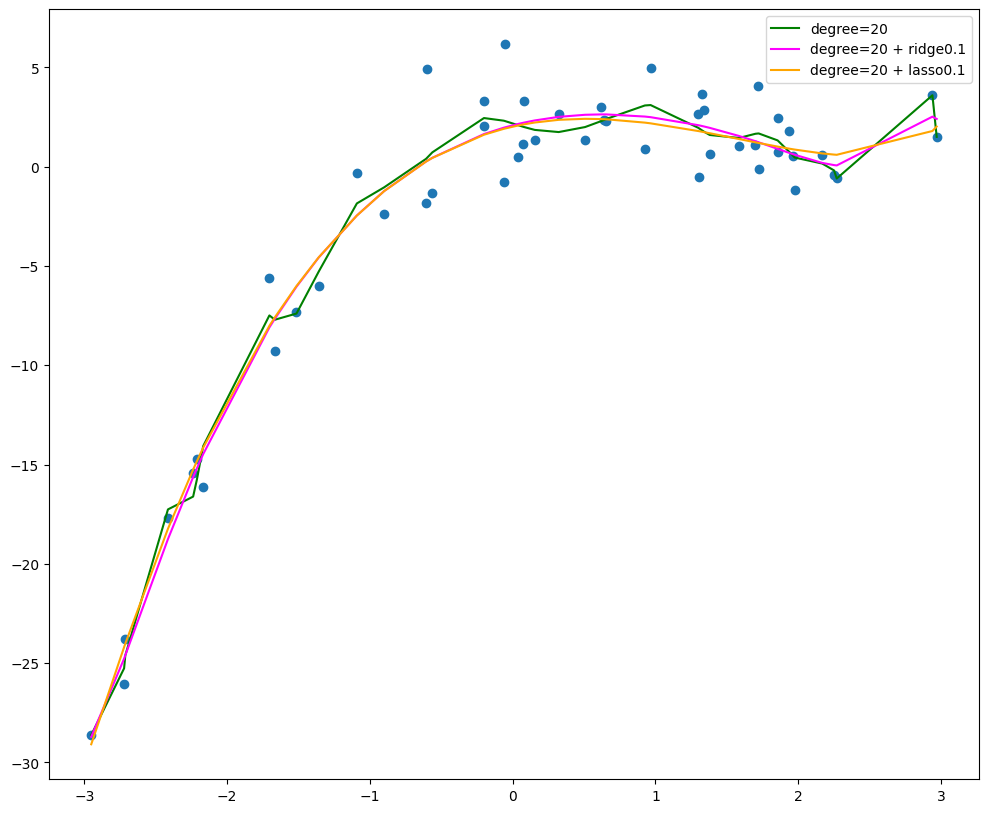

In [26]:
#wykres dopasowania dla regresji wielomianowej bez kary, z karą ridge i z karą lasso
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()

#widzimy, że i ridge i lasso się nie przeuczyło

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianej stopnia 2, 10 i 20,
- wielomianej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

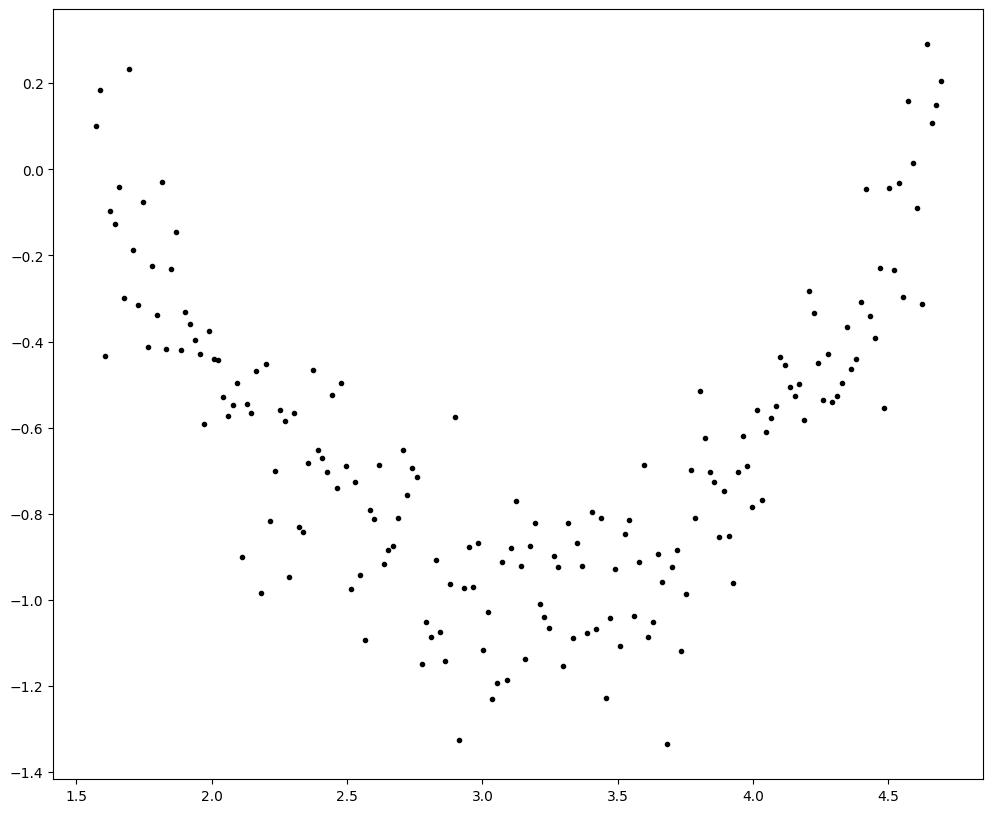

In [27]:
#generacja danych
x = np.array([i*np.pi/180 for i in range(90,270,1)])
X = pd.DataFrame(x)
y = np.cos(x)+np.random.normal(0,0.15,len(x))
plt.plot(x,y,'.',color = 'black')

In [28]:
#funkcja dopasowywująca modele, które nas interesują
def fit_model(X,y,model,power):
  new_model = make_pipeline(
      PolynomialFeatures(degree = power,include_bias = False),
      StandardScaler(),
      model
  )
  new_model.fit(X,y)
  return(new_model.predict(X))

In [29]:
#tworzymy modele
models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [30]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)
def rss_fun(y,y_pred):
  return(sum((y-y_pred)**2))

In [31]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model
y_pred_dict = {}
rss = {}
for key,values in zip(models,models.values()):
  y_pred = fit_model(X,y,values['model'],values['power'])
  y_pred_dict[key] = y_pred
  rss[key] = rss_fun(y_pred,y)

In [32]:
pd.DataFrame(list(rss.items()),columns = ['Model','RSS'])
#nie dziwi, że RSS najmniejsze dla regresji wielomianu 20 stopnia, bo ten model najlepiej dopasuje się do danych na których był uczony, 
#ale na innym zbiorze danych już pewnie taki nie będzie (overfitting) 

,Model,RSS
0,linear_regression,21.870477
1,polynomial_regression2,4.293317
2,polynomial_regression10,4.078446
3,polynomial_regression20,3.894646
4,ridge_regression_0.1,4.180396
5,lasso_regression_0.1,16.684355


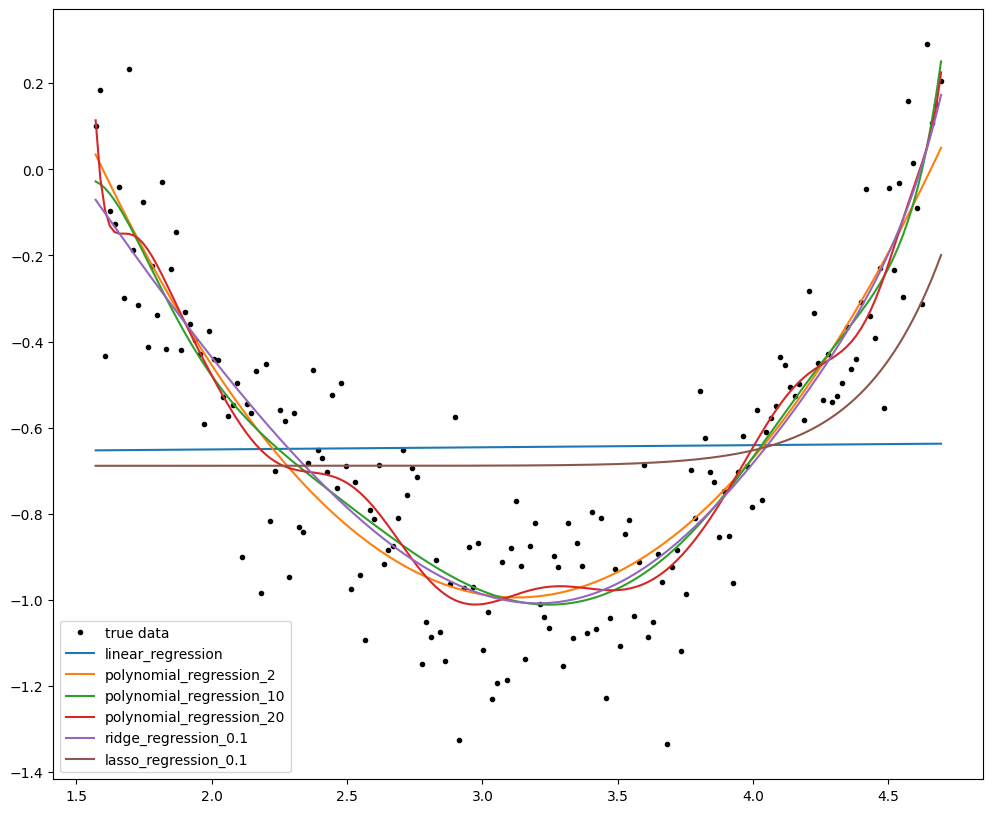

In [34]:
rcParams['figure.figsize'] = 12, 10

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")
for y_pred in y_pred_dict.values():
    plt.plot(x, y_pred)
plt.legend(labels)

#polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony - potrzebna mniejsza alpha